In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
print(os.listdir())  # Menampilkan semua file di folder saat ini



['.config', 'drive', 'helper_functions.py', 'sample_data']


In [3]:
!pip install torchinfo
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [4]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    val_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS
):
    # Use ImageFolder to create datasets
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    val_data = datasets.ImageFolder(val_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn image datasets into DataLoaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    val_dataloader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_dataloader, val_dataloader, test_dataloader, class_names



In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloaders(
       train_dir = '/content/drive/MyDrive/Fundus_dataset/training',
       val_dir = '/content/drive/MyDrive/Fundus_dataset/validation',
       test_dir = '/content/drive/MyDrive/Fundus_dataset/testing',
    transform=transform,
    batch_size=16
)

train_dataloader, val_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b724366fc10>,
 ['cataract', 'diabetic', 'glaucoma', 'normal'])

In [17]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

class_names = ['cataract','diabetic','glaucoma','normal']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


Using device: cuda


In [7]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(16, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]

)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [16, 3, 224, 224]    [16, 4]              768                  Partial
├─Conv2d (conv_proj)                                         [16, 3, 224, 224]    [16, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [16, 197, 768]       [16, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [16, 197, 768]       [16, 197, 768]       --                   --
│    └─Sequential (layers)                                   [16, 197, 768]       [16, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [16, 197, 768]       [16, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [16, 197, 768]       [16, 

In [8]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [9]:
"""
Contains functions for training and validating a PyTorch model.
"""
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics to get average
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval()

    # Setup validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            val_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # Calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item() / len(val_pred_labels))

    # Adjust metrics to get average
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}

    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        val_loss, val_acc = val_step(model=model,
                                     dataloader=val_dataloader,
                                     loss_fn=loss_fn,
                                     device=device)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    return results


optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

results = train(
    model=pretrained_vit,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=25,
    device=device
)



  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7228 | train_acc: 0.7277 | val_loss: 0.5802 | val_acc: 0.7913
Epoch: 2 | train_loss: 0.5005 | train_acc: 0.8209 | val_loss: 0.5428 | val_acc: 0.8059
Epoch: 3 | train_loss: 0.4346 | train_acc: 0.8472 | val_loss: 0.4975 | val_acc: 0.8297
Epoch: 4 | train_loss: 0.3892 | train_acc: 0.8676 | val_loss: 0.4786 | val_acc: 0.8391
Epoch: 5 | train_loss: 0.3579 | train_acc: 0.8786 | val_loss: 0.5469 | val_acc: 0.8016
Epoch: 6 | train_loss: 0.3420 | train_acc: 0.8826 | val_loss: 0.4955 | val_acc: 0.8281
Epoch: 7 | train_loss: 0.3158 | train_acc: 0.8922 | val_loss: 0.5614 | val_acc: 0.7891
Epoch: 8 | train_loss: 0.2994 | train_acc: 0.9030 | val_loss: 0.4658 | val_acc: 0.8453
Epoch: 9 | train_loss: 0.2870 | train_acc: 0.9016 | val_loss: 0.5057 | val_acc: 0.8172
Epoch: 10 | train_loss: 0.2740 | train_acc: 0.9115 | val_loss: 0.5418 | val_acc: 0.7984
Epoch: 11 | train_loss: 0.2646 | train_acc: 0.9111 | val_loss: 0.4681 | val_acc: 0.8281
Epoch: 12 | train_loss: 0.2544 | train_ac

In [10]:
import os

save_path = "/content/drive/MyDrive/hasil"
os.makedirs(save_path, exist_ok=True)  # Ini akan membuat folder jika belum ada


In [11]:
# Menyimpan hanya state_dict (direkomendasikan)
torch.save(pretrained_vit.state_dict(), "/content/drive/MyDrive/hasil/model_vit.pth")


In [12]:
def plot_loss_curves(results):
    import matplotlib.pyplot as plt

    loss = results["train_loss"]
    val_loss = results["val_loss"]

    accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(10, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="Train loss")
    plt.plot(epochs, val_loss, label=" Val loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="Train acc")
    plt.plot(epochs, val_accuracy, label="Val acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()


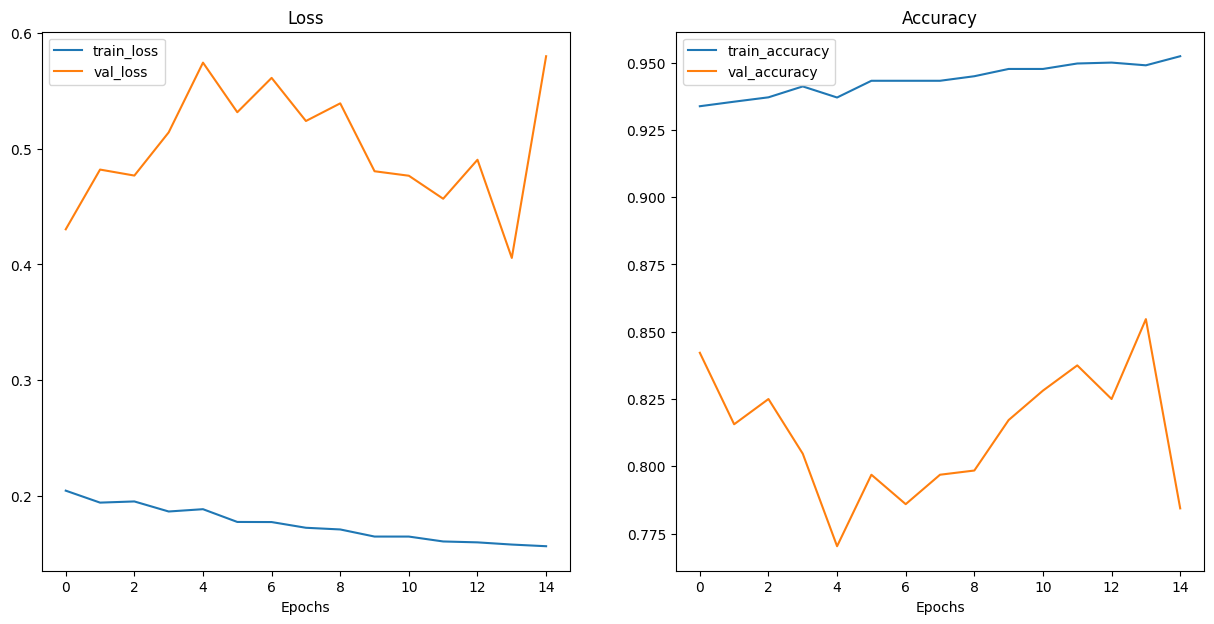

In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(results)

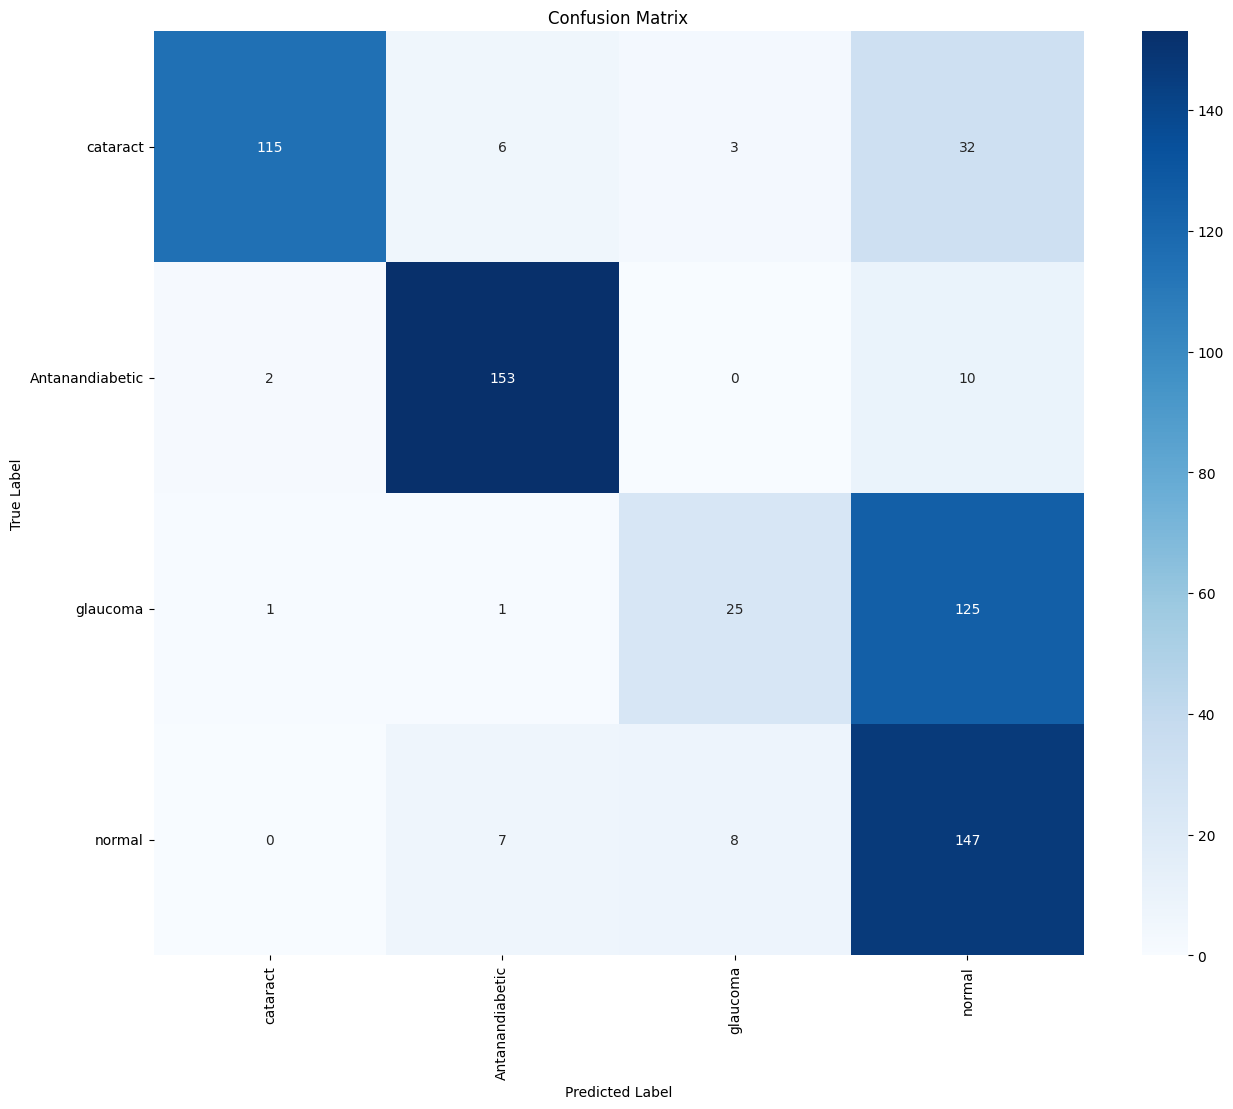

                 precision    recall  f1-score   support

       cataract       0.97      0.74      0.84       156
Antanandiabetic       0.92      0.93      0.92       165
       glaucoma       0.69      0.16      0.27       152
         normal       0.47      0.91      0.62       162

       accuracy                           0.69       635
      macro avg       0.76      0.68      0.66       635
   weighted avg       0.76      0.69      0.67       635



In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluasi model di data test
all_preds = []
all_labels = []

pretrained_vit.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_logits = pretrained_vit(X)
        y_pred = torch.argmax(y_logits, dim=1)

        all_preds.append(y_pred.cpu())
        all_labels.append(y.cpu())

# Gabungkan semua prediksi dan label
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names))


Saving 1272_right.jpg to 1272_right.jpg


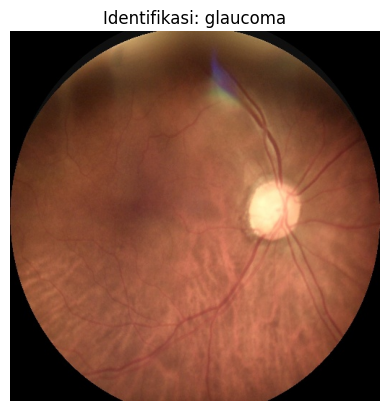

✅ Identifikasi Penyakit Mata: glaucoma (36.50%)
🧾 Deskripsi:
Glaukoma adalah kerusakan saraf optik akibat peningkatan tekanan intraokular, sering tanpa gejala hingga stadium lanjut.

🩺 Rekomendasi Edukatif:
1. Glaukoma bersifat irreversibel, maka deteksi dini sangat penting.
2. Segera kunjungi dokter mata untuk pemeriksaan tekanan bola mata dan lapang pandang.
3. Pengobatan meliputi obat tetes mata (misal: prostaglandin, beta blocker), terapi laser, atau operasi.
4. Disarankan pemeriksaan mata rutin bagi orang dengan riwayat keluarga glaukoma.



In [21]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Edukasi berdasarkan hasil klasifikasi
edukasi_penyakit = {
    "normal": """🧾 Deskripsi:
Citra fundus menunjukkan struktur retina yang normal, tidak terdapat tanda-tanda katarak, glaukoma, atau retinopati diabetik.

🩺 Rekomendasi Edukatif:
1. Pertahankan gaya hidup sehat, termasuk konsumsi makanan bergizi dan cukup vitamin A.
2. Lakukan pemeriksaan mata rutin setiap 6–12 bulan, terutama bagi yang berisiko tinggi (penderita diabetes, hipertensi, usia lanjut).
3. Hindari paparan cahaya matahari langsung tanpa pelindung mata.
4. Jaga kadar gula darah dan tekanan darah tetap stabil.
""",

    "cataract": """🧾 Deskripsi:
Katarak adalah kekeruhan pada lensa mata yang menyebabkan penglihatan kabur, terutama pada malam hari atau saat melihat cahaya terang.

🩺 Rekomendasi Edukatif:
1. Segera periksakan ke dokter spesialis mata untuk memastikan derajat kekeruhan lensa.
2. Pada tahap awal, penggantian kacamata bisa membantu, namun pada tahap lanjut mungkin perlu operasi penggantian lensa (fakoemulsifikasi).
3. Hindari merokok dan kontrol penyakit penyerta seperti diabetes.
4. Gunakan kacamata hitam saat di luar ruangan untuk mengurangi paparan sinar UV.
""",

    "glaucoma": """🧾 Deskripsi:
Glaukoma adalah kerusakan saraf optik akibat peningkatan tekanan intraokular, sering tanpa gejala hingga stadium lanjut.

🩺 Rekomendasi Edukatif:
1. Glaukoma bersifat irreversibel, maka deteksi dini sangat penting.
2. Segera kunjungi dokter mata untuk pemeriksaan tekanan bola mata dan lapang pandang.
3. Pengobatan meliputi obat tetes mata (misal: prostaglandin, beta blocker), terapi laser, atau operasi.
4. Disarankan pemeriksaan mata rutin bagi orang dengan riwayat keluarga glaukoma.
""",

    "diabetic retinopathy": """🧾 Deskripsi:
Komplikasi mata akibat diabetes melitus yang ditandai oleh kerusakan pembuluh darah di retina, bisa menyebabkan kebutaan jika tidak ditangani.

🩺 Rekomendasi Edukatif:
1. Kontrol gula darah secara ketat dan rutin periksa HbA1c (< 7% ideal).
2. Lakukan pemeriksaan retina minimal 1x setahun jika mengidap diabetes.
3. Pengobatan meliputi fotokoagulasi laser, injeksi anti-VEGF, atau operasi vitrektomi tergantung tingkat keparahan.
4. Konsultasi dengan dokter spesialis retina sangat dianjurkan.
"""
}

# Upload gambar
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

# Prediksi
pretrained_vit.eval()
with torch.inference_mode():
    prediction_logits = pretrained_vit(img_tensor)
    prediction_probs = torch.softmax(prediction_logits, dim=1)
    predicted_class_index = torch.argmax(prediction_probs, dim=1).item()

predicted_class = class_names[predicted_class_index]
confidence = torch.max(prediction_probs).item() * 100

# Tampilkan gambar dan hasil
plt.imshow(img)
plt.axis('off')
plt.title(f"Identifikasi: {predicted_class}")
plt.show()

print(f"✅ Identifikasi Penyakit Mata: {predicted_class} ({confidence:.2f}%)")

# Tampilkan manfaatnya jika tersedia
edukasi = edukasi_penyakit.get(predicted_class.lower(), "❌ Belum ada informasi edukatif untuk penyakit ini.")
print(edukasi)
